In this notebook, I'll look at strategies to transfer data from train to test region and evaluate the accuracy of the same.

In [1]:
import pandas as pd

In [2]:
from train_test import *

In [3]:
train_region = "SanDiego"
test_region = "Austin"

train_dataset_df = df_regions[train_region]
test_dataset_df = df_regions[test_region]

train_all_homes = home_regions[train_region]
test_all_homes = home_regions[test_region]

appliance="hvac"

In [4]:
from train_test import _find_accuracy

acc = {}
pred_all = {}
gt_all = {}
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        pred_all[appliance] = {}
        gt_all[appliance] = {}
        feature="Monthly"
        for home in test_all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(train_dataset_df, test_dataset_df,
                   train_all_homes, test_all_homes,
                   home, appliance, feature="Monthly")
                
                acc[appliance][home]=out_df
                pred_all[appliance][home] = pred
                gt_all[appliance][home] = gt
                print home, acc[appliance][home].mean()
            except Exception, e:
                print e

hvac
26 26.9145828533
59 55.2871099365


In [6]:
acc

{'hvac': {26: 7    20.489400
  8    17.859870
  9    42.394478
  Name: 26, dtype: float64, 59: 7    55.461868
  8    36.250737
  9    74.148725
  Name: 59, dtype: float64}}

In [5]:
pd.DataFrame(acc['hvac']).T.mean()

7    37.975634
8    27.055304
9    58.271601
dtype: float64

In [11]:
pd.DataFrame(acc['hvac']).T.describe()

,7,8,9
count,75.000000,75.000000,75.000000
mean,33.875164,34.551412,59.590807
std,13.506503,14.299504,17.179150
min,0.000000,14.970531,32.207546
25%,25.402136,24.092669,45.621805
50%,32.206694,31.408983,57.202514
75%,38.968379,40.700078,69.224408
max,71.943419,76.328550,98.588914


In [80]:
def oracle(train_dataset_df, test_dataset_df,
                   train_all_homes, test_all_homes,
                   home, appliance):
    from itertools import combinations
    out = {appliance:{}}
    
    for home in test_all_homes[appliance]:
        out[appliance][home] = {"best_prediction_array":{}, "best_score":1e7, "optimal_subset":{}}


    appliance_columns = {
                         'hvac':["hvac_%d" % i for i in range(7, 10)]}

    errors_dict = {}
    for appliance in appliance_columns.keys():
        errors_dict[appliance] = {}
        for max_length in range(1, 3):
            print max_length
            errors_dict[appliance][max_length] = {}
            all_combinations = combinations(train_all_homes[appliance], max_length)
            for train_homes in all_combinations:

                test_homes = test_all_homes[appliance]
                for home in test_homes:
                    
                    pred_home = np.mean(train_dataset_df.ix[list(train_homes)][appliance_columns[appliance]])
                    gt_home = test_dataset_df.ix[home][appliance_columns[appliance]]
                    
                    error = np.mean(100*(gt_home-pred_home).abs().div(gt_home))
                   
                    if error<out[appliance][home]['best_score']:
                        
                        errors_dict[appliance][max_length][home] = 100*(gt_home-pred_home).abs().div(gt_home)
                        
                        out[appliance][home]['best_score'] = error
                        out[appliance][home]['optimal_subset'] = train_homes
                        out[appliance][home]['best_prediction_array'] = pred_home
    return errors_dict, out

In [108]:
train_region = "San Diego"
test_region = "Austin"

train_dataset_df = df_regions[train_region]
test_dataset_df = df_regions[test_region]

train_all_homes = home_regions[train_region]
test_all_homes = home_regions[test_region]

appliance="hvac"


e, o = oracle(train_dataset_df, test_dataset_df,
                   train_all_homes, test_all_homes,
                   home, appliance)

1
2


In [109]:
oracle_accuracy = (100-pd.Series({f:pd.DataFrame(e[f][2]).mean().mean() for f in appliance_columns.keys()}))

In [110]:
oracle_accuracy

hvac    82.922066
dtype: float64

In [111]:
pd.DataFrame(e['hvac'][2]).T.describe()

,hvac_7,hvac_8,hvac_9
count,41.000000,41.000000,41.000000
mean,15.197844,26.664714,9.371245
std,10.615671,15.165396,7.598981
min,0.200355,0.077628,0.068852
25%,5.490701,18.455735,2.930430
50%,14.708170,30.932296,6.887019
75%,21.410119,37.831905,13.338868
max,45.075491,60.661014,25.748720


Now, transforming train_dataset HVAC by cooling days

In [89]:
cdd = {'Austin':{7:715, 8: 788, 9:588},
      'San Diego':{7:428, 8:433, 9:472}}

In [91]:
cdd_df = pd.DataFrame(cdd)

In [85]:
train_dataset_df_copy  = df_regions[train_region].copy()

In [92]:
for month in [7, 8, 9]:
    cdd_month = cdd_df.ix[month]
    train_dataset_df_copy['hvac_%d' %month] = train_dataset_df_copy['hvac_%d' %month]* cdd_month[test_region]/cdd_month[train_region]

In [93]:
train_dataset_df_copy.head()

,aggregate_7,aggregate_8,aggregate_9,hvac_7,hvac_8,hvac_9,fridge_7,fridge_8,fridge_9,dw_7,dw_8,dw_9,mw_7,mw_8,mw_9
54,0.265679,0.275405,0.167601,249.431753,288.297280,149.595485,37.834301,38.103199,28.727217,15.490267,14.173583,8.487300,7.218117,2.903950,1.892617
203,0.490503,0.397438,0.275920,432.457951,423.537537,217.490693,56.448948,44.765385,39.742134,0.599217,0.000667,0.545717,11.203717,9.830317,7.555984
1450,0.700644,0.935066,0.863948,495.229495,826.382259,585.053517,72.587753,54.018948,52.222767,19.510000,22.250017,19.913500,19.398167,26.427166,14.663067
1731,0.619553,0.627770,0.787347,483.826623,555.079452,486.273674,44.515667,45.955036,42.599567,4.947166,4.171333,5.398050,5.765916,6.296000,6.078183
2354,0.665513,0.595442,0.668042,585.551170,542.311154,385.061346,NaN,NaN,NaN,19.126434,18.484699,17.355982,22.555834,22.376900,18.119551


In [95]:
e, o = oracle(train_dataset_df_copy, test_dataset_df,
                   train_all_homes, test_all_homes,
                   home, appliance)

1
2


In [96]:
oracle_accuracy_transfer = (100-pd.Series({f:pd.DataFrame(e[f][2]).mean().mean() for f in appliance_columns.keys()}))

In [97]:
oracle_accuracy_transfer

hvac    93.655213
dtype: float64

In [103]:
o['hvac'][624]

{'best_prediction_array': hvac_7    340.944852
 hvac_8    355.917409
 hvac_9    183.543089
 dtype: float64, 'best_score': 5.818516172186336, 'optimal_subset': (54, 203)}

In [104]:
train_dataset_df_copy.ix[[54, 203]]

,aggregate_7,aggregate_8,aggregate_9,hvac_7,hvac_8,hvac_9,fridge_7,fridge_8,fridge_9,dw_7,dw_8,dw_9,mw_7,mw_8,mw_9
54,0.265679,0.275405,0.167601,249.431753,288.297280,149.595485,37.834301,38.103199,28.727217,15.490267,14.173583,8.487300,7.218117,2.903950,1.892617
203,0.490503,0.397438,0.275920,432.457951,423.537537,217.490693,56.448948,44.765385,39.742134,0.599217,0.000667,0.545717,11.203717,9.830317,7.555984


In [107]:
pd.DataFrame(e['hvac'][2]).T.describe()

,hvac_7,hvac_8,hvac_9
count,54.000000,54.000000,54.000000
mean,5.064148,7.941698,6.028515
std,4.390296,8.364522,12.719468
min,0.194121,0.282512,0.026314
25%,1.538836,2.555043,1.323856
50%,3.483055,5.894230,3.127265
75%,8.117787,10.361773,5.954200
max,17.543412,48.688165,89.005136


In [112]:
monthwise = pd.DataFrame({'without':[85, 73, 91], 'with':[95, 91, 87]}, index=["July",'Aug', "Sep"])

In [113]:
monthwise

,with,without
July,95,85
Aug,91,73
Sep,87,91


In [116]:
train_dataset_df[['fridge_7']].median()

fridge_7    47.000734
dtype: float64

In [117]:
test_dataset_df[['fridge_7']].median()

fridge_7    57.035515
dtype: float64

In [118]:
train_dataset_df[['aggregate_7']].median()

aggregate_7    0.280536
dtype: float64

In [119]:
test_dataset_df[['aggregate_7']].median()

aggregate_7    0.350729
dtype: float64

In [122]:
unscaled_test_df = pd.read_csv('../data/input/unscaled_austin_df.csv',index_col=0)

In [123]:
unscaled_train_df = pd.read_csv('../data/input/unscaled_san_diego_df.csv',index_col=0)

In [126]:
%matplotlib inline

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  app.launch_new_instance()
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


{'boxes': [<matplotlib.lines.Line2D at 0x11b7ee650>],
 'caps': [<matplotlib.lines.Line2D at 0x11b7d1510>,
 'fliers': [<matplotlib.lines.Line2D at 0x11b723e90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11b721c10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11b7e51d0>,
  <matplotlib.lines.Line2D at 0x11b7da990>]}

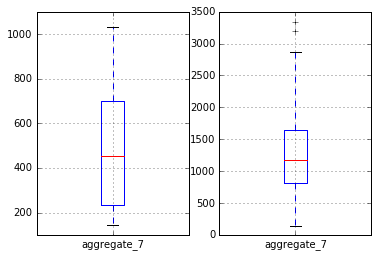

In [130]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2)
unscaled_train_df[['aggregate_7']].boxplot(ax=ax[0])
unscaled_test_df[['aggregate_7']].boxplot(ax=ax[1])

In [154]:
month = 7
cdd_month = cdd_df.ix[month]
hvac_adjustment = unscaled_train_df[['hvac_7']]*(cdd_month[test_region]*1./cdd_month[train_region]-1.)
hvac_adjustment.columns = ["aggregate_7"]
#fridge_adjustment = pd.Series(unscaled_train_df[['fridge_7']]*1.2).values)
(unscaled_train_df[['aggregate_7']] + hvac_adjustment+fridge_adjustment)

,aggregate_7
54,581.661786
203,926.233492
1450,1203.318381
1731,1075.326753
2354,NaN
2606,NaN
3687,1221.773726
3864,473.526374
3938,382.944770
4083,306.183504


In [136]:
unscaled_train_df[['aggregate_7']].median()

aggregate_7    452.578735
dtype: float64

In [137]:
unscaled_test_df[['aggregate_7']].median()

aggregate_7    1172.03894
dtype: float64

In [143]:
hvac_adjustment = unscaled_train_df[['hvac_7']]*cdd_month[test_region]/cdd_month[train_region]

In [152]:
hvac_adjustment+unscaled_train_df[['aggregate_7']]

,aggregate_7
54,436.139069
203,684.906738
1450,917.428650
1731,827.700623
2354,878.555725
2606,652.447693
3687,859.141663
3864,337.748779
3938,284.619446
4083,217.443024


In [153]:
hvac_adjustment

,aggregate_7
54,0
203,0
1450,0
1731,0
2354,0
2606,0
3687,0
3864,0
3938,0
4083,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11cf03590>], dtype=object)

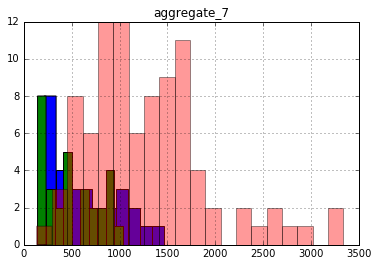

In [163]:
ax = plt.gca()
(unscaled_train_df[['aggregate_7']] + hvac_adjustment+fridge_adjustment).hist(ax=ax)
(unscaled_train_df[['aggregate_7']]).hist(ax=ax, bins=10)
(unscaled_test_df[['aggregate_7']]).hist(ax=ax, bins=20, alpha=0.4)

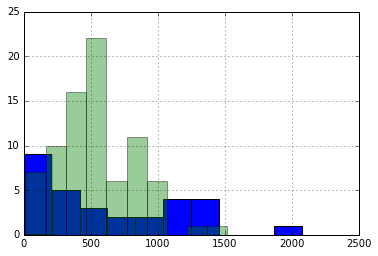

In [174]:
(4*train_dataset_df['hvac_%d' %month]).hist()
test_dataset_df['hvac_%d' %month].hist(alpha=0.4)

In [169]:
cdd

{'Austin': {7: 715, 8: 788, 9: 588}, 'San Diego': {7: 428, 8: 433, 9: 472}}

In [171]:
train_dataset_df['hvac_%d' %month].median()

128.087474823

In [172]:
test_dataset_df['hvac_%d' %month].median()

487.873474121

In [175]:
from sklearn.linear_model import LinearRegression

In [176]:
clf = LinearRegression()

In [183]:
clf.fit(train_dataset_df.ix[train_all_homes["hvac"]]['hvac_%d' %month],train_dataset_df.ix[train_all_homes["hvac"]]['aggregate_%d' %month] )

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found arrays with inconsistent numbers of samples: [ 1 26]

In [184]:
train_dataset_df.ix[train_all_homes["hvac"]]['hvac_%d' %month]

54      149.310196
203     258.869934
1450    296.445068
1731    289.619293
2354    350.511749
2606    286.592285
3687    289.946289
3864    125.890953
3938     61.706448
4083     66.353279
4095    324.804688
4934     40.959435
6377     31.260134
6429     49.736618
6547     32.152950
7114    182.314209
7409     61.922935
7639    130.283997
8061    315.256561
8574     55.605553
8733    234.299011
9213     81.591278
9370    519.166382
9585    191.078262
9612    330.617310
9775      0.002467
Name: hvac_7, dtype: float64

In [192]:
Y = unscaled_train_df.ix[train_all_homes["hvac"]]['aggregate_%d' %month].reshape(-1,1)
X = train_dataset_df.ix[train_all_homes["hvac"]]['hvac_%d' %month].reshape(-1,1)

In [193]:
clf.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [196]:
clf.coef_,clf.intercept_

(array([[ 1.85531288]]), array([ 191.57789171]))

In [197]:
Y = unscaled_test_df.ix[test_all_homes["hvac"]]['aggregate_%d' %month].reshape(-1,1)
X = test_dataset_df.ix[test_all_homes["hvac"]]['hvac_%d' %month].reshape(-1,1)
clf = LinearRegression()
clf.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
clf.coef_,clf.intercept_

(array([[ 1.91717064]]), array([ 240.80689441]))